## Chargement des données

Importation des librairies utilisées dans le calepin.

// TODO: à enlever à la fin:

Pour importer librairies:
using Pkg
Pkg.add(["CSV", "DataFrames", "Combinatorics", "Gadfly", "Distributions"], ...)

In [984]:
#= import Pkg; Pkg.add("Plots")
import Pkg; Pkg.add("DecisionTree") =#

In [985]:
using CSV, DataFrames, Statistics, Dates, Gadfly, LinearAlgebra, DecisionTree,Random, Plots

In [986]:
function standardize(data)
    return (data .- mean(data)) ./ std(data)
end

function standardize_data(data)
    stddata = deepcopy(data)
   for col in names(stddata)
        if eltype(stddata[!, col]) <: Number && col != "id"
            stddata[!, col] = standardize(stddata[!, col])
        end
    end
    return stddata
end

standardize_data (generic function with 1 method)

In [987]:
function encode(data, column)
    for c in unique(data[!, column])
        data[!, Symbol(c)] = ifelse.(data[!, column] .== c, 1, 0)
    end
    return data
end

function encode_data(data)
    encoded_data = deepcopy(data)
    encoded_data = encode(encoded_data, :general_type)
    encoded_data = encode(encoded_data, :transmission)
    encoded_data = encode(encoded_data, :boite)
    return encoded_data
end

encode_data (generic function with 1 method)

In [988]:
function removeRows(data)
    return select!(data, Not([:type, :transmission, :boite, :general_type]))
end

removeRows (generic function with 1 method)

In [989]:
function add_general_type(data :: DataFrame)
    data = deepcopy(data)
    general_type_dict = Dict("voiture_moyenne" => "voiture", "VUS_petit" => "VUS", "voiture_compacte" => "voiture", "voiture_deux_places" => "voiture", "voiture_minicompacte" => "voiture", "VUS_standard" => "VUS", "monospace" => "camionnette", "voiture_sous_compacte" => "voiture", "camionnette_petit" => "camionnette", "break_petit" => "break", "voiture_grande" => "voiture", "camionnette_standard" => "camionnette", "break_moyen" => "break", "voiture_sport" => "voiture_sport")
    
    data[!,:volume_gaz] = data[!,:nombre_cylindres] .* data[!,:cylindree]

    data.type = ifelse.(data.type .== "voiture_deux_places"   .&& data.boite.=="manuelle" .&& data.cylindree .>= 4 , "voiture_sport" , data.type)

    #= println(sum(data.type .== "voiture_deux_places" .&& data.volume_gaz .> 45 .&& data.transmission .== "integrale" )) =#

    data.general_type = [general_type_dict[t] for t in data.type]
    return data
end



add_general_type (generic function with 1 method)

In [990]:
# sort(d[d.general_type .== "voiture_sport", :], :consommation, rev=true)

In [991]:
# add_general_type(testData)[testData.general_type .== "voiture_sport", :]

In [992]:
function add_rows(data)
    data[!,:volume_gaz] = data[!,:nombre_cylindres] .* data[!,:cylindree]

    # https://www.insurancenavy.com/average-car-weight/
    # https://www.auto-tests.com/fr/lightest-weight/Wagon/all/
    weight_dict = Dict("voiture_moyenne" => 3300, "VUS_petit" => 3500, "voiture_compacte" => 2800, "voiture_deux_places" => 2800, "voiture_minicompacte" => 1500, "VUS_standard" => 5000, "monospace" => 4500, "voiture_sous_compacte" => 2600, "camionnette_petit" => 4200, "break_petit" => 2640, "voiture_grande" => 4400, "camionnette_standard" => 4700, "break_moyen" => 3300)
    data[!, :weight] = [weight_dict[t] for t in data[!, :type]]

    data = add_general_type(data)
    
    # display(plot(data, x=:general_type, y=:consommation, color=:type))
    # println(combine(groupby(data, :type), nrow => :count))
    return data
end

add_rows (generic function with 1 method)

In [993]:
function getStandardEncodedData(data)
    data_copy = deepcopy(data)
    standardised_data = add_rows(data_copy)
    standardised_data = standardize_data(data_copy)
    # standardised_data = encode_data(standardised_data)
    standardised_data = removeRows(standardised_data)
    return standardised_data
end

    



getStandardEncodedData (generic function with 1 method)

In [994]:
function rmse(y, ychap)
    return sqrt(mean((ychap .- y).^2))
end


rmse (generic function with 1 method)

In [995]:
function rsquared(y, ychap)
    ss_total = sum((y .- mean(y)).^2)
    ss_res = sum((y .- ychap).^2)
    return ss_res / ss_total
end


rsquared (generic function with 1 method)

In [996]:
function train_test_split(data, test_size=0.2, shuffle=true)
    n = size(data, 1)
    test_size = floor(Int, n * test_size)
    
    if shuffle
        indices = randperm(n)
    else
        indices = 1:n
    end
    
    test_indices = indices[1:test_size]
    train_indices = indices[test_size+1:end]
    
    train_data = data[train_indices, :]
    test_data = data[test_indices, :]
    
    return train_data, test_data
end

train_test_split (generic function with 3 methods)

In [997]:
trainData = CSV.read("../../data/train.csv", DataFrame)
testData = CSV.read("../../data/test.csv", DataFrame)
trainData.consommation = parse.(Float64,replace.(trainData.consommation, "," => "."))
trainData.cylindree = parse.(Float64,replace.(trainData.cylindree, "," => "."))
testData.cylindree = parse.(Float64,replace.(testData.cylindree, "," => "."))


COMSOMMATION_MEAN = mean(trainData.consommation)
COMSOMMATION_STD = std(trainData.consommation)
trainData[!, :id] = 1:nrow(trainData)
testData[!, :id] = 1:nrow(testData)
# trainData[!, :nrow] .= 1
# testData[!, :nrow] .= 1



1:150

In [998]:
function evaluate_rmse(data)
    nrange = 1000
    n = 0
    for i in range(0, 1, length=nrange)
        n += regression(data)[1]
    end
    print("average rmse for regression: ", n/nrange, "\n")
end


evaluate_rmse (generic function with 1 method)

In [999]:
function remise(prediction)
    id = 1:150
    df_pred = DataFrame(id=id, consommation=prediction)

   format_file(df_pred)
end

function format_file(predictions,i)
    #println(predictions)
    current_time = Dates.format(now(), "yyyy-mm-dd_HH-MM-SS")
    file_name = "benchmark_$i.csv"
    CSV.write("./" *file_name, predictions)
end

format_file (generic function with 1 method)

In [1000]:
function get_unique_data(data, columns_to_compare)
    unique_data = combine(groupby(data, columns_to_compare), :consommation => mean)
    rename!(unique_data, :consommation_mean => :consommation)
   return unique_data
end

function find_pairs(data_train, data_predict, columns_to_compare)
    train_data_without_consommation = select(data_train, Not(:consommation))
    predict_data_without_annee = select(data_predict, Not(:annee))
    common_values = innerjoin(data_train, data_predict, on=columns_to_compare)
    return common_values
end
    

find_pairs (generic function with 1 method)

In [1001]:
function forest_regression(training_data, test_data)
    ids = test_data.id

    y_train = training_data.consommation
    common_columns = intersect(names(training_data), names(test_data))
    training_data = training_data[:, common_columns]
    test_data = test_data[:, common_columns]

    X_train = Matrix(training_data[:, Not(:annee, :id)])
    X_test = Matrix(test_data[:, Not(:annee, :id)])

    model = RandomForestRegressor(n_subfeatures=5, n_trees=1000,min_samples_leaf=1,min_purity_increase=0.0, max_depth=5, min_samples_split=6)
    fit!(model, X_train, y_train)
    ychap =  predict(model, X_test)  

    prediction = DataFrame(id=ids, consommation=ychap)

    return prediction    
end

forest_regression (generic function with 1 method)

In [1002]:
COLUMNS_TO_COMPARE_1 = ["type", "nombre_cylindres", "cylindree", "transmission", "boite"]
COLUMNS_TO_COMPARE_2 = ["nombre_cylindres", "cylindree", "type" ]
COLUMNS_TO_COMPARE_3 = ["nombre_cylindres", "cylindree"]

trainData.type = ifelse.(trainData.type .== "break_petit", "break_moyen", trainData.type)
testData.type = ifelse.(testData.type .== "break_moyen", "break", testData.type)

testData.type = ifelse.(testData.type .== "camionnette_standard", "cam", testData.type)

trainData = filter(row -> row.type != "monospace", trainData)
trainData.type = ifelse.(trainData.type .== "voiture_deux_places" .&& trainData.nombre_cylindres .>= 8 .&& trainData.boite .== "manuelle" .&& trainData.transmission .== "integrale", "voiture_sport", trainData.type)
testData.type = ifelse.(testData.type .== "voiture_deux_places" .&& testData.nombre_cylindres .>= 8 .&& testData.boite .== "manuelle" .&& testData.transmission .== "integrale", "voiture_sport", testData.type)

function match_predictions(train_data, data_to_predict, pairs, columns_to_compare)
    unique_data = get_unique_data(train_data, columns_to_compare)
    new_pairs = find_pairs(unique_data, data_to_predict, columns_to_compare)
    new_pairs = select(new_pairs, [:id, :consommation])
    pairs = vcat(pairs, new_pairs)
    data_to_predict = filter(row -> !(row.id in pairs.id), data_to_predict)
    return pairs, data_to_predict
end

function main(trainData, testData)
    pairs = DataFrame(id=Int[], consommation=Float64[])
    pairs, testData = match_predictions(trainData, testData, pairs, COLUMNS_TO_COMPARE_1)

    data_to_predict_by_forest = deepcopy(testData)
    perfect_match_pairs = deepcopy(pairs)

    
    pairs, testData = match_predictions(trainData, testData, pairs, COLUMNS_TO_COMPARE_2)
    pairs, testData = match_predictions(trainData, testData, pairs, COLUMNS_TO_COMPARE_3)

    ids_with_no_match = testData.id


    forest_predictions = forest_regression(trainData, data_to_predict_by_forest)

    no_match_predictions = forest_predictions[forest_predictions.id .== ids_with_no_match, :]

    matching_predictions = vcat(pairs, no_match_predictions)
    sort!(matching_predictions, :id)

    forest_predictions = vcat(perfect_match_pairs, forest_predictions)
    sort!(forest_predictions, :id)

    average_predictions = (matching_predictions.consommation .+ forest_predictions.consommation) ./ 2

    average_predictions = DataFrame(id=1:150, consommation=average_predictions)

    println(average_predictions[5,:])


    return average_predictions

end
average_predictions = main(trainData, testData)


DataFrameRow
 Row │ id     consommation 
     │ Int64  Float64      
─────┼─────────────────────
   5 │     5       13.8195


Row,id,consommation
,Int64,Float64
1,1,8.11069
2,2,7.59532
3,3,8.66848
4,4,8.71148
5,5,13.8195
6,6,13.8359
7,7,13.8359
8,8,10.2265
9,9,10.9459


In [1003]:
# ptree = tree_regression(trainData, testData, out)

# average_data = (out.consommation .+ ptree.consommation) ./ 2

# average_data = DataFrame(id=1:150, consommation=average_data)


# # format_file(average_data, 105)
# print(1)


In [1004]:
data_17 = CSV.read("./benchmark18_equipe_T.csv", DataFrame)
# data_tree = CSV.read("./benchmark_2.csv", DataFrame)
# data_out = CSV.read("./benchmark_1.csv", DataFrame)

sort(data_17, :id)

difference = average_predictions.consommation - data_17.consommation

diff_df = DataFrame(id=average_data.id, diff=difference)

filtered_diff_df = filter(row -> abs(row.diff) > 0.1, diff_df)

common_ids = intersect(pairs_2.id, filtered_diff_df.id)

# println(common_ids)

total_diff = sum(abs.(diff_df.diff).^2)/150

println(total_diff)

println(filtered_diff_df)


8.12192649124015e-5
0×2 DataFrame
 Row │ id     diff    
     │ Int64  Float64 
─────┴────────────────


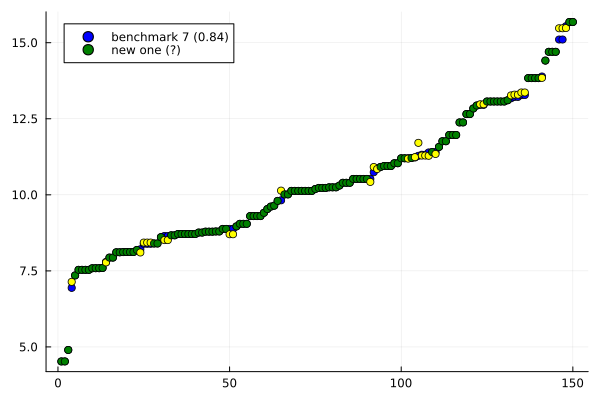

In [1005]:
common_ids = intersect(data_17.id, average_data.id)
diff_ids = filter(id -> data_17[data_17.id .== id, :consommation] != average_data[average_data.id .== id, :consommation], common_ids)
data_1_common = filter(row -> row.id in common_ids, data_17)
data_2_common = filter(row -> row.id in common_ids, average_data)


data_1_sorted = sort(data_17, :consommation)
data_2_sorted = [average_data.consommation[i] for i in data_1_sorted.id]
#= data_3_sorted = [data_3.consommation[i] for i in data_1_sorted.id]
 =#
colors1 = [(i in common_ids ? :blue : :blue) for i in data_1_sorted.id]
colors2 = [(i in diff_ids ? :yellow : :green) for i in data_1_sorted.id]
#= colors3 = [(i in common_ids ? :black : :white) for i in data_1_sorted.id]
 =#

scatter(1:150, data_1_sorted.consommation, c=colors1, label="benchmark 7 (0.84)")
scatter!(1:150, data_2_sorted, c=colors2, label= "new one (?)")

In [1006]:
uniqueD = get_unique_data(trainData, COLUMNS_TO_COMPARE_1)
uniqueD[ uniqueD.type .== "voiture_deux_places", : ]

#sort(trainData, :consommation, rev=true)

#essayer, plutot que d'enlever une colonne automatiquement, essayer de réduire le nb d'états possibles, ex : integrale => propulsion 

Row,type,nombre_cylindres,cylindree,transmission,boite,consommation
,Abstract…,Int64,Float64,String15,String15,Float64
1,voiture_deux_places,8,5.0,integrale,automatique,13.0672
2,voiture_deux_places,6,3.0,propulsion,automatique,10.5223
3,voiture_deux_places,6,3.0,integrale,automatique,11.2005
4,voiture_deux_places,8,4.2,integrale,automatique,13.8359
5,voiture_deux_places,10,5.2,integrale,automatique,14.4124
6,voiture_deux_places,4,2.0,propulsion,automatique,9.04654
7,voiture_deux_places,8,5.0,propulsion,automatique,12.6546
8,voiture_deux_places,6,3.0,propulsion,manuelle,12.838
9,voiture_deux_places,8,6.2,propulsion,manuelle,13.1077


In [1007]:
differentIds = [10
11
39
45
49
72
98
112
132]

9-element Vector{Int64}:
  10
  11
  39
  45
  49
  72
  98
 112
 132

In [1008]:
idProblematiques = [57	
99	
109	
119]

testData[idProblematiques, :]
out[idProblematiques, :]

Row,id,consommation
,Int64,Float64
1,57,11.2005
2,99,11.2328
3,109,11.2005
4,119,11.1954
